## KUBIG 2021-2 코드 분석 스터디 2주차: Binary Classification  
  **13기** 김현지

### 필사할 캐글 커널: EDA To Prediction(Die Tanic)
https://www.kaggle.com/ash316/eda-to-prediction-dietanic

# 0. Kaggle과 Colab 연결하기

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khyeonji","key":"8df0ab35b9d8f3ec572e6a14329987db"}'}

In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c titanic

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 10.7MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 57.1MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.51MB/s]


In [6]:
!ls

gender_submission.csv  kaggle.json  sample_data  test.csv  train.csv


# EDA To Prediction (DieTanic)

### **Contents of the Notebook**

**Part1: Exploratory Data Analysis(EDA)**


1.   Analysis of the features.
2.   Finding any relations or trends considering multiple features.

**Part2: Feature Engineering and Data Cleaning**


1.   Adding any few features.
2.   Removing redundant features.
3.   Converting features into suitable form for modeling.

**Part3: Predictive Modeling**


1.   Running Basic Algorithms.
2.   Cross Validation.
3.   Ensembling.
4.   Important Features Extraction.







# Part1: Exploratory Data Analysis(EDA)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
data = pd.read_csv('/content/train.csv')

In [9]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# 결측값 확인
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age, Cabin, Embarked 변수가 결측치를 가지고 있다. 추후에 처리를 하도록 한다.

**How many Survived?**   얼마나 살아남았을까?

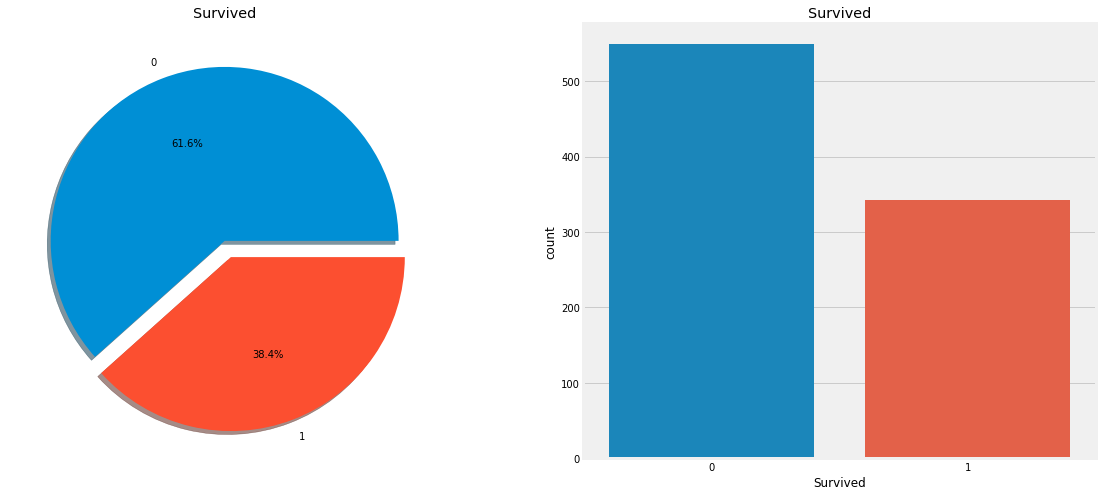

In [11]:
f,ax = plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=data, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

이 사고에서 살아남은 승객은 많지 않다.

train set의 891명의 승객 중 약 350만명만이 살아남았다. 즉 전체 train set의 38.4%만이 살아남은 것이다. 우리는 데이터로부터 더 나은 인사이트를 얻고, 어떤 승객들이 살아남고 누가 살아남지 못했는지를 알아내기 위해 더 많은 것을 파헤칠 필요가 있다.

우린 데이터셋의 다른 피쳐를 사용해 생존율을 확인해보고자 한다. 피쳐에는 Sex, Port of Embarcation, Age 등이 있다.

먼저 타입별 피쳐들을 이해해보자.

### Types Of Features

**Categorical Features:**

범주형 변수는 두 개 이상의 범주가 있는 변수이며 해당 피쳐의 각 값은 한 변수로 분류된다. 예를 들어, sex는 두 범주(남성 혹은 여성)를 갖는 범주형 변수이다 이런 변수들을 정렬하거나 순위를 매길수도 없다. Nominal variable이라고도 한다.

*   **Categorical Features in the dataset:** Sex, Embarked

**Ordinal Features:**

순서형 변수는 범주형 변수의 값과 유사하지만, 값 간의 상대적인 순서나 정렬이 가능하다. 예를 들어 Tall, Medium, Short의 값을 가진 Height는 순서형 변수이다. 변수에서 상대적인 정렬을 할 수 있다.



*   **Ordinal Features in the dataset:** PClass

**Continous Feature:**

연속된 실수 값을 가지는 경우 연속형 변수라고한다.



*   **Continous Features in the dataset:** Age

### Analysing The Features

### Sex -> Categorical Feature

In [12]:
data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

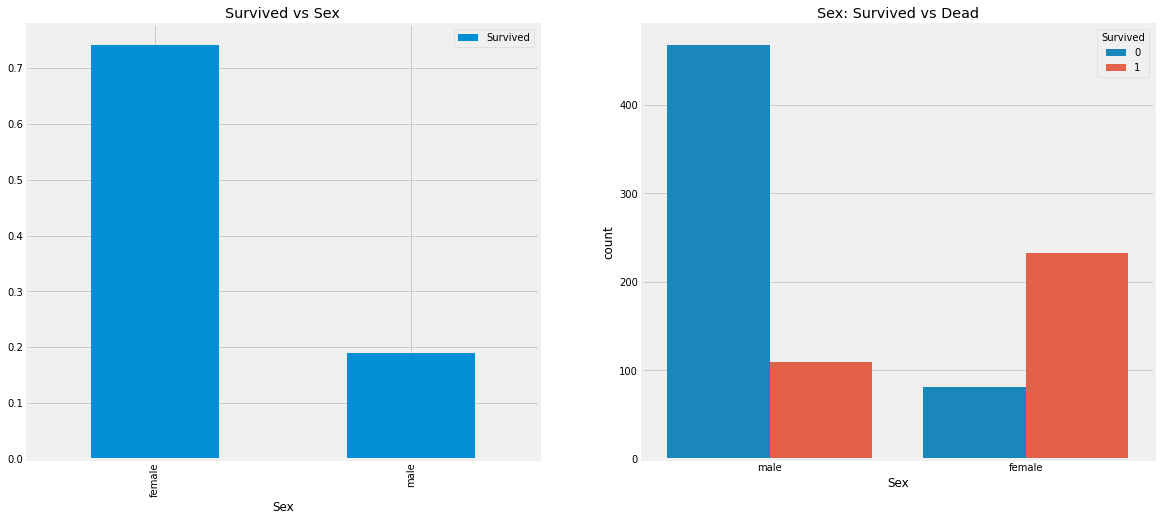

In [13]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
data[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

배에 탄 남자의 수가 여자의 수보다 훨씬 많지만 살아남은 여성의 수는 남성의 거의 두 배이다. 배에 타고 있는 여성의 생존율은 약 75%, 남성은 약 18-19% 정도이다.

이 사실은 모델링에 있어 Sex라는 피쳐가 아주 주요해 보인다. 다른 피쳐들도 확인해보자.

### Pclass -> Ordinal Feature

In [14]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


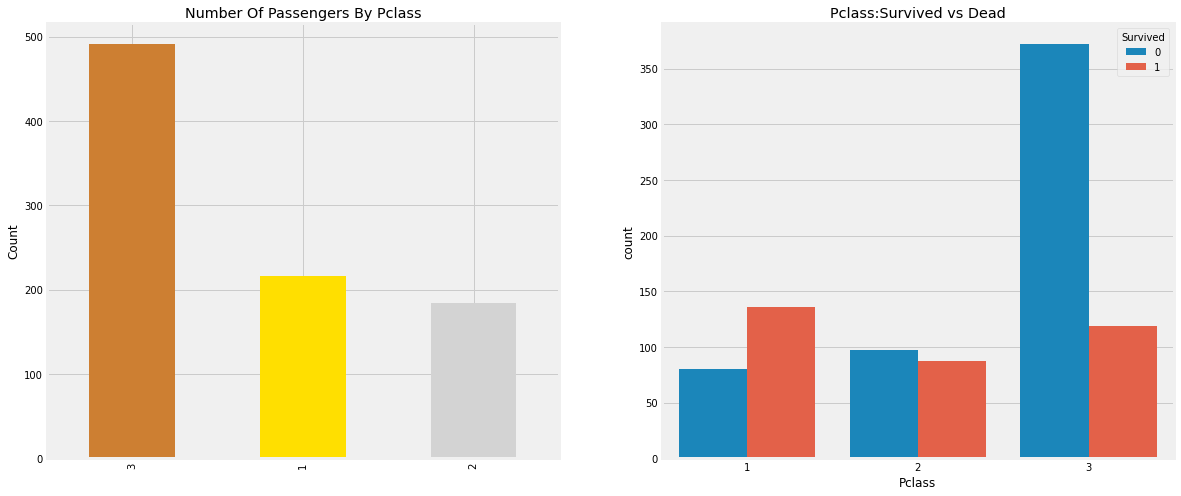

In [15]:
f,ax = plt.subplots(1,2,figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

사람들은 돈으로 모든 것을 살 수 없다고 말하지만, 구조하는 동안 pclass의 1 승객들이 높은 우선 수위를 부여받았음을 알 수 있다. pclass 3의 승객 수가 훨씬 더 많았지만, 생존율은 25% 정도로 매우 낮다.

plcass 1의 경우 생존율이 약 63%인 반면 pclass의 경우 약 48%이다. 그래서 돈과 지위가 중요하다. 슬프게도 물질만능주의적인 세상이다.

다음으로 sex와 pclass를 함께 사용해서 생존율을 확인해보자.

In [16]:
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient(cmap='summer_r')

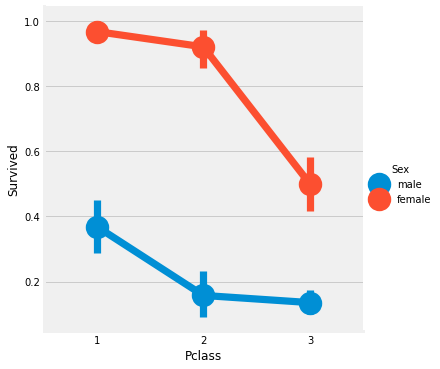

In [17]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=data)
plt.show()

이 경우에는 범주형 값을 쉽게 분리할 수 있기 때문에 Factorplot을 사용한다.

Cross Tab과 FactorPlot을 보면 pclass 1의 여성 94명 중 3명만이 사망했기 때문에 Pclass 1의 여성 생존율이 약 95-96% 임을 알 수 있다.

pclass와 관계없이 구조 과정에서 여성에게 우선권이 주어졌음이 분명하다. pclass 1의 남성도 생존율이 매우 낮다.

pclass도 중요한 피쳐인거 같다. 다른 피쳐들도 분석해보자.

### Age -> Continous Feature

In [18]:
print('Oldest Passenger was of:', data['Age'].max(), 'Years')
print('Youngest Passenger was of:', data['Age'].min(), 'Years')
print('Average Age on the ship:', data['Age'].mean(), 'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


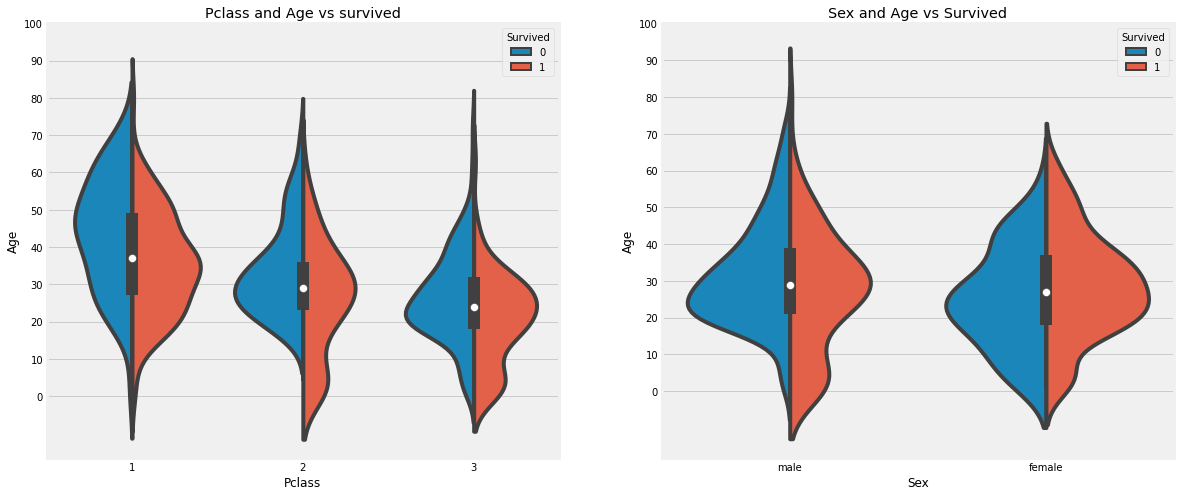

In [19]:
f,ax = plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass", "Age", hue="Survived", data=data, split=True, ax=ax[0])
ax[0].set_title("Pclass and Age vs survived")
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot("Sex", "Age", hue="Survived", data=data, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

**Observation**


1.   pclass에 따라 어린이의 수가 증가하며, 10세 미만의 승객의 생존율은 pclass에 관계없이 양호한 것으로 보인다.
2.   pclass 1의 20-50세 승객들의 생존확률이 높고, 여성일수록 높다.
3.   남성은 나이가 들수록 생존 가능성이 낮아진다.



앞에서 살펴본 것과 같이 Age 피쳐는 177개의 null 값을 가진다. 이러한 null 값을 대체하기 위해 데이터 셋에서 평균 값을 할당할 수 있다.

하지만 문제는 많은 다양한 연령대의 사람들이 있다는 것이다. 우리는 4살 아이에게 평균값인 29세를 할당할 수는 없다. 승객이 어떤 연령대인지 가늠할 수는 없을까?

Name 피쳐를 확인할 수 있다. 그 피쳐들을 보면 우리는 Mr 또는 Mrs 같은 salutation을 가지고 있다는 것을 알 수 있다.따라서 우리는 Mr와 Mrs의 평균값을 각각의 그룹에 할당할 수 있다.

**"What's in A Name? -> Feature:** p

In [20]:
data['Initial'] = 0
for i in data:
  # Salutations 추출하기
  data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.')

여기서는 정규식 ([A-Za-z]+) 을 사용한다. A-Z 또는 a-z 사이에 있는 문자로 되어있고, 뒤에 .(점)이 오는 문자열을 찾는다. 따라서 이름에서 이니셜을 성공적으로 추출했다.

In [21]:
# Sex와 함께 Initials를 확인해보자
pd.crosstab(data.Initial, data.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


MIIe이나 Mme와 같이 철자는 다르지만 Miss와 같이 여성을 나타낼 수 있다. 그것들을 Miss로 대체한다.

In [22]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [23]:
# Initials 별로 age를 확인해보자.
data.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

**Filling NaN Ages**

In [24]:
data.loc[(data.Age.isnull())&(data.Initial=='Mr'), 'Age'] = 33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [25]:
data.Age.isnull().any()

False

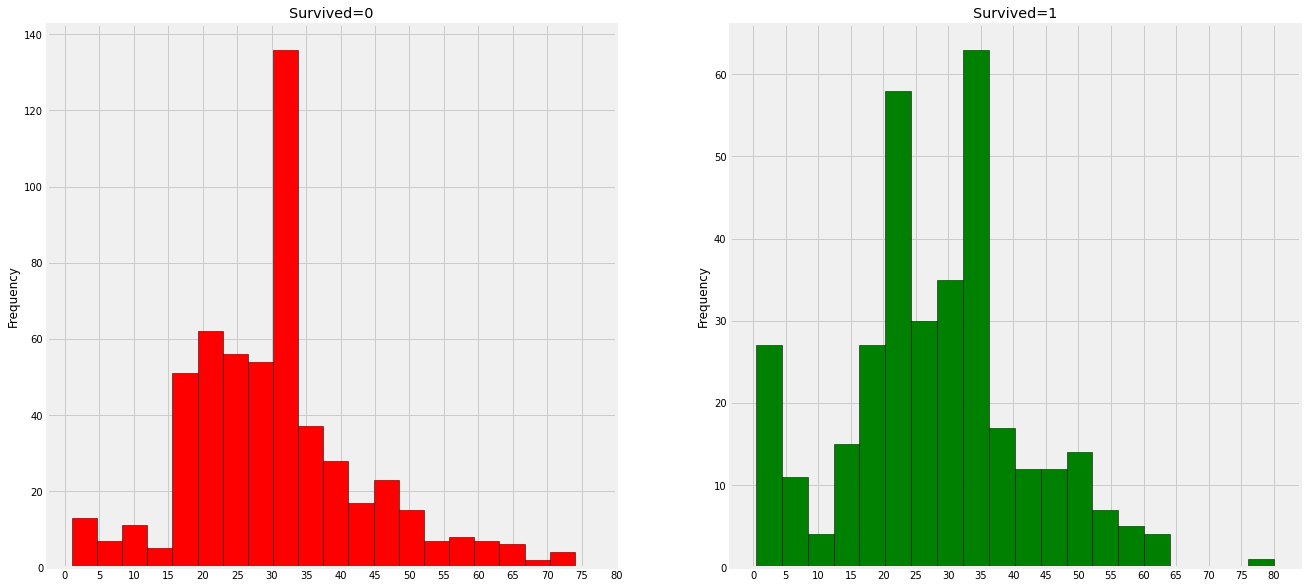

In [26]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0], bins=20, edgecolor='black', color='red')
ax[0].set_title('Survived=0')
x1 = list(range(0, 85, 5))
ax[0].set_xticks(x1)
data[data['Survived']==1].Age.plot.hist(ax=ax[1], color='green', bins=20, edgecolor='black')
ax[1].set_title('Survived=1')
x2 = list(range(0, 85, 5))
ax[1].set_xticks(x2)
plt.show()

**Observations:**


1.   유아(5세 이하)들은 아주 많이 구조되었다. (여성 및 아동 우선 정책)
2.   최고령자(80세)가 구조되었다.
3.   30-40세 사망자가 가장 가장 많다.



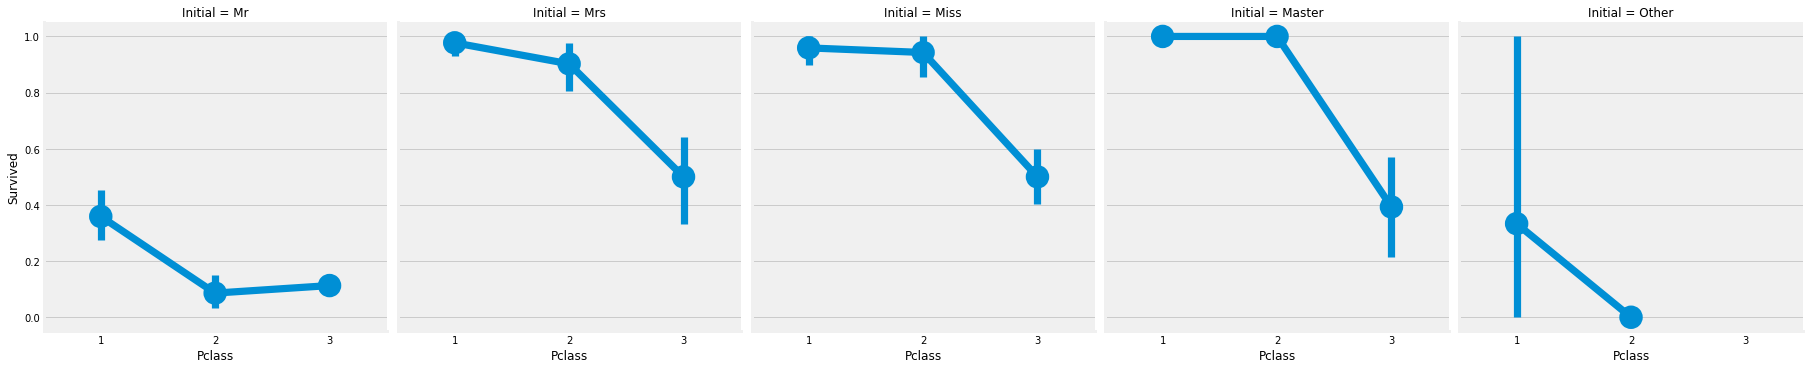

In [27]:
sns.factorplot('Pclass','Survived', col='Initial', data=data)
plt.show()

### Embarked -> Categorical Value

In [28]:
pd.crosstab([data.Embarked, data.Pclass], [data.Sex, data.Survived], margins=True).style.background_gradient(cmap='summer_r')

**Port of Embarkation에 따른 생존율 변화**

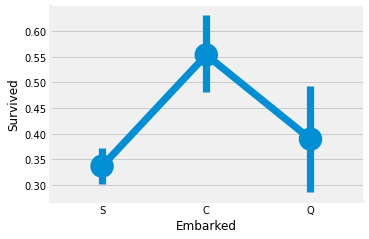

In [29]:
sns.factorplot('Embarked', 'Survived', data=data)
fig = plt.gcf()
fig.set_size_inches(5, 3)
plt.show()

port C의 생존율은 약 0.55이고 S의 생존율이 가장 낮다.

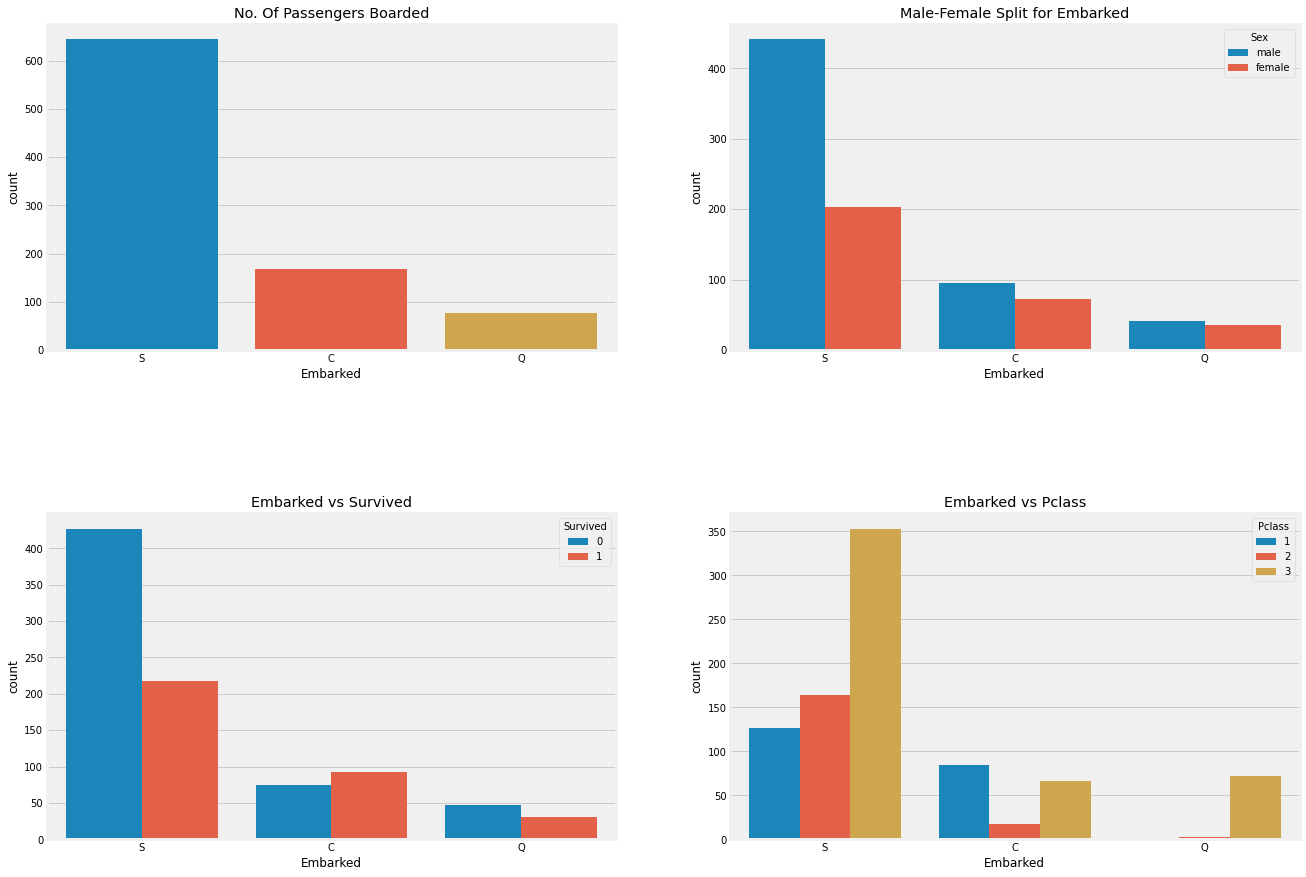

In [30]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=data,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

**Observations:**


1.   S에서 탑승한 승객이 가장 많다. 그들 중 대부분은 pclass 3 승객이다.
2.   C에서 탄 승객의 생존율이 높은 이유는 클래스가 높은 사람이 많이 타서 그렇다.
3.   Q에서 탄 승객의 약 95%는 Pclass3 승객이다.



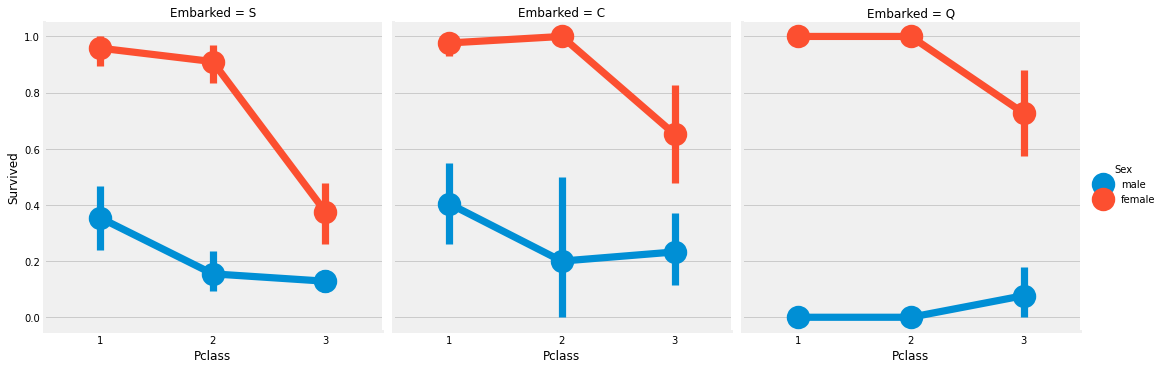

In [31]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

**Observations:**


1.  pclass1과 pclass2의 생존 확률은 pclass에 관계없이 거의 1이다.
2.  pclass3 승객의 경우 남녀 모두 생존율이 매우 낮기 때문에 항구 S에서 탄 승객들의 생존율이 낮다.(돈 문제)
3.   Q에서 탄 승객들 중 남자들은 Pclass3 승객이 많기 때문에 생존율이 매우 낮다.

**Filling Embarked NaN**

대부분의 승객들이 S항구에서 탔기 때문에 NaN을 S로 교체한다.

In [32]:
data['Embarked'].fillna('S', inplace=True)

In [33]:
data.Embarked.isnull().any()

False

### SibSip -> Discrete Feature

이 피쳐는 한 사람이 혼자 있는지 아니면 가족과 함께 있는지를 나타낸다.


*   Sibling = 남자형제, 여자형제, 이복형제
*   Spouse = 남편, 아내



In [34]:
pd.crosstab([data.SibSp],data.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


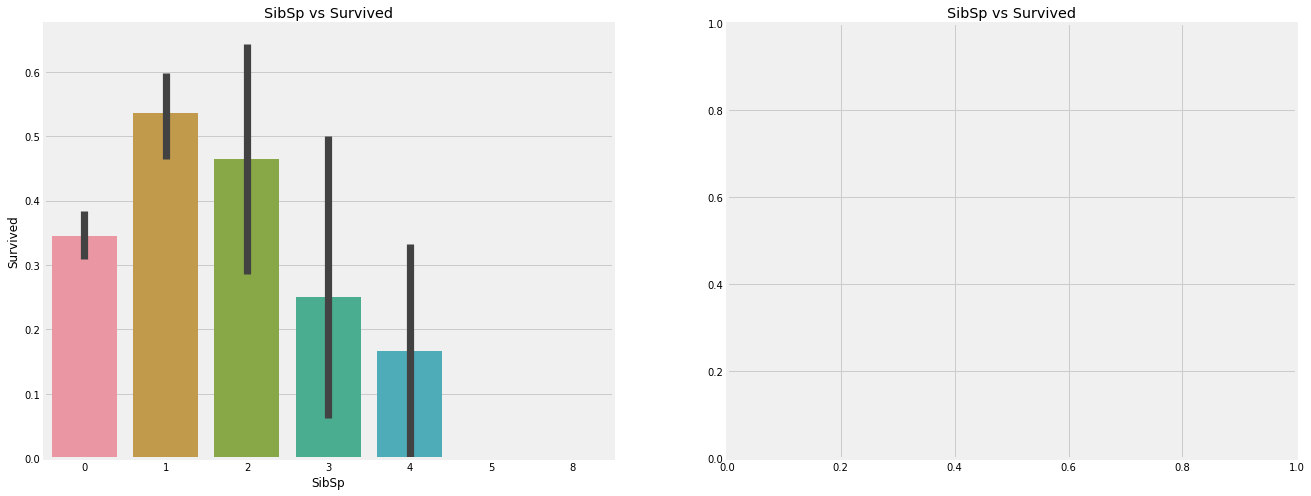

In [35]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=data,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()

In [36]:
pd.crosstab(data.SibSp,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


**Observations**

barplot과 factorplot을 보면 가족 없이 혼자 탑승한 승객의 생존율이 34.5%임을 알 수 있다. 형제자매 수가 증가할수록 그래프는 대략적으로 감소한다.즉, 만약 배에 가족이 있다면 자신을 먼저 구하는 대신 가족들을 구하려고 노력할 것이다. 놀랍게도 5-8명 가족의 생존율은 0%이다. 그 이유는 pclass일까?

그 이유는 pclass이다. 크로스탭은 Sibsp>3 값을 가지는 사람이 모두 pclass3에 속한다는 것을 보여준다. pclass 3의 대가족은 대부분 모두 사망했다.

### Parch

In [37]:
pd.crosstab(data.Parch,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


크로스탭은 pclass3에 대가족이 있었다는 것을 다시 보여준다.

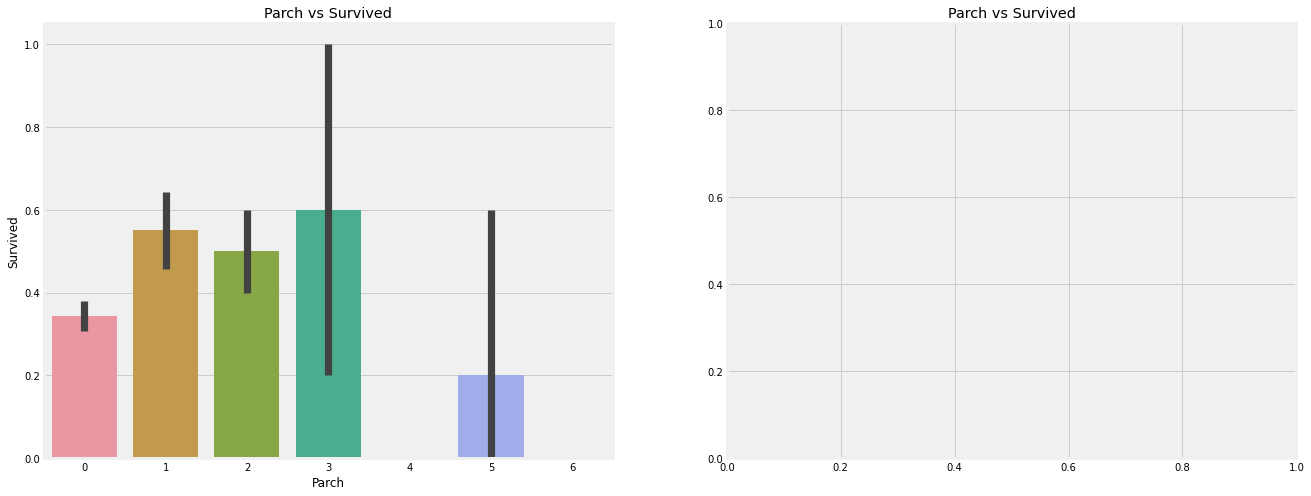

In [38]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('Parch','Survived',data=data,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch','Survived',data=data,ax=ax[1])
ax[1].set_title('Parch vs Survived')
plt.close(2)
plt.show()

**Observation**

여기서도 결과는 매우 비슷하다. 부모가 탑승한 승객들은 생존 가능성이 더 높다. 그러나 숫자가 증가할수록 감소한다.

배에 1-3명의 부모를 둔 사람들은 생존율이 높다. 혼자 탄 경우와 4명이상의 부모와 함께 탄 경우 생존율은 낮아진다.

### Fare -> Continous Feature

In [39]:
print('Highest Fare was:',data['Fare'].max())
print('Lowest Fare was:',data['Fare'].min())
print('Average Fare was:',data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


최저요금은 0이다. 

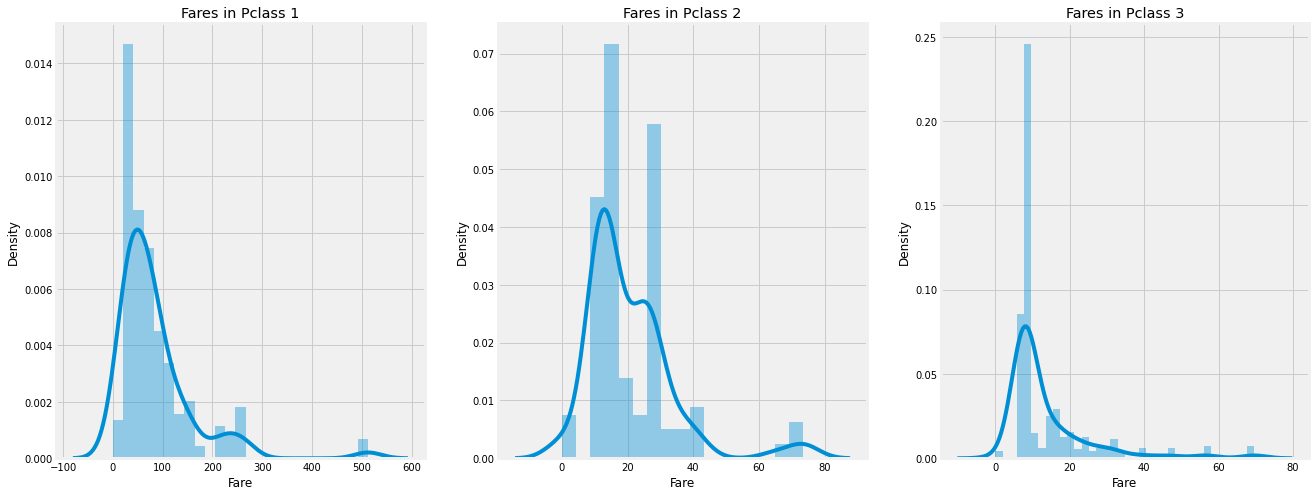

In [40]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

pclass1의 승객 운임에는 큰 분포가 있을 것으로 보이며 이 분포의 기준이 감소함에 따라 줄어든다. 이 또한 연속적이기 때문이 binning을 사용해 이산값으로 변환할 수 있다.

### Observations in a Nutshell for all features:



*   **Sex:** 여성의 생존율이 남성보다 높다.
*   **Pclass:** 1등석 승객일수록 생존확률이 높아진다. pclass3의 생존율은 매우 낮다. 여성의 경우 pclass1의 생존율은 거의 1이며 plcass2일 때도 높다.
*   **Age:** 5-10세 미만의 어린이들은 생존 가능성이 높다. 15세에서 35세 사이의 승객들은 많이 죽었다.
*  **Embarked:**이것은 매우 흥미로운 피쳐이다. Q항구에서 pclass 1 승객의 대다수가 pclass3에서 출발했음에도 불구하고 C에서 출발했을때 생존율이 더 높다.
*   **Parch+SinSp:**1-2명의 형제자매, 배우자 또는 1-3명의 부모가 있는 것은 혼자 있거나 대가족이 함께 여행하는 것보다 생존율이 더 높자는 것을 보여준다.








### Correlation Between The Features

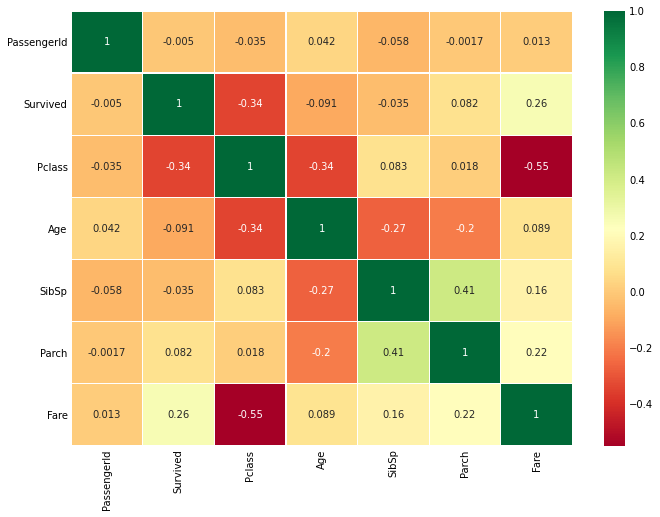

In [41]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.show()

**Interpreting The Heatmap**

거의 유사한 피쳐들이 있는 경우 학습시간 등을 줄이기 위해 중복된 피쳐들을 제거하려고 노력해야 한다.

그러나 위의 히트맵을 보면 피쳐들이 큰 상관관계가 없다는 것을 알 수 있다. 가장 높은 상관관계는 SibSp과 Parch의 0.41이다. 따라서 모든 피쳐를 계속 사용할 수 있다.

# Part2: Feature Engineering and Data Cleaning

Feature engineering이란 무엇일까?

피쳐가 포함된 데이터 셋을 사용할 때마다 모든 피쳐가 중요하지는 않을 것이다. 제거되어야할 많은 중복되는 피쳐들이 있을 수 있다. 또한 다른 피쳐에서 정보를 추출하여 새로운 피쳐를 가져오거나 추가할 수 있다.

Name Feature를 사용해서 Initals 피쳐를 가져온 것도 한 예이다. 새로운 피쳐가 있는지 알아보고 몇 가지 피쳐를 제거할 수 있는지도 알아보겠다. 또한 기존의 피쳐들을 예측 모델링에 적합한 형태로 변경한다.

### Age_band

**Problem With Age Feature:**
Age는 연속형 변수이며, 머신러닝 모델에서 연속형 변수는 문제가 있다.

예를 들어 운동 선수를 성별에 따라 분류하거나 배열하라고 하면 우리는 남성과 여성으로 쉽게 분리할 수 있다.

나이별로 분류하라고 하면 어떨까? 30명이 있으면 나이 값이 30개 일 수 있다. 이것은 문제가 있다.

우리는 이런 연속 값을 binning 또는 정규화를 통해 범주형 값으로 변환할 필요가 있다. binning을 사용하자. 즉, 하나의 bin으로 연련 범위를 그룹화 하거나 단일 값을 할당한다.

승객의 최대 연령은 80세였다. 0-80을 5개의 bin으로 나누자. 80/5=16이다. bin의 크기는 16이다.

In [42]:
data['Age_band'] = 0
data.loc[data['Age']<=16, 'Age_band'] = 0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [43]:
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')

,Age_band
1,382
2,325
0,104
3,69
4,11


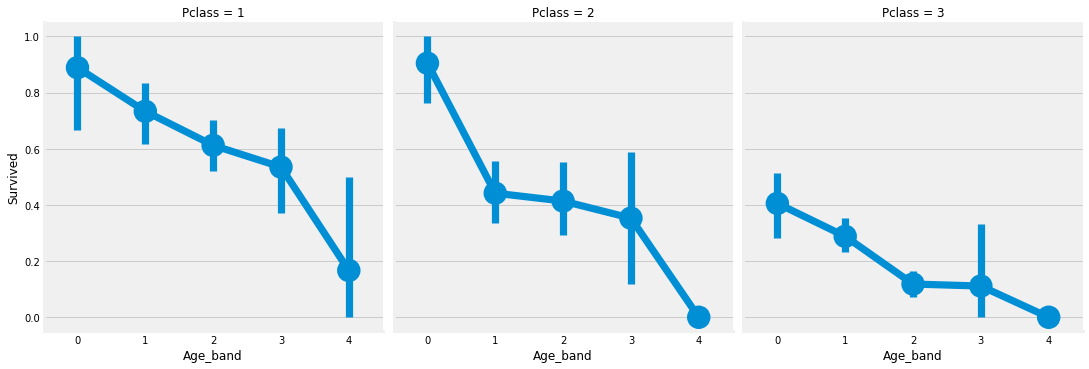

In [44]:
sns.factorplot('Age_band','Survived',data=data,col='Pclass')
plt.show()

생존율은 pclass에 관계없이 연령이 증가함에 따라 감소한다.

### Family_Size and Alone

여기서 Famliy_size와 Alon이라는 새 피쳐를 만들 수 있다. 이 피쳐는 Parch와 SibSp의 합이다. 이건 우리에게 생존율이 승객의 가족 크기와 관련이 있는지 확인할 수 있도록 우리에게 결합된 데이터를 제공한다. Alone은 승객이 혼자인지 아닌지 알 수 있다.

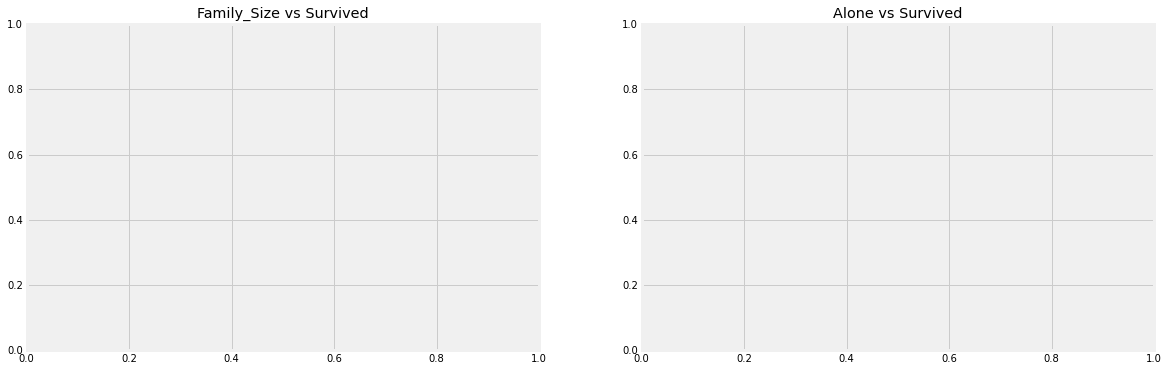

In [45]:
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_Size','Survived',data=data,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone','Survived',data=data,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

Family_size=0은 승객이 혼자임을 의미한다. 분명 혼자이거나 family_size=0인 경우에는 생존율이 매우 낮다. 가족 수가 4를 넘을 때도 생존율이 줄어든다. 이것은 또한 모델에 중요한 피쳐로 보인다. 자세한 내용을 살펴보자.

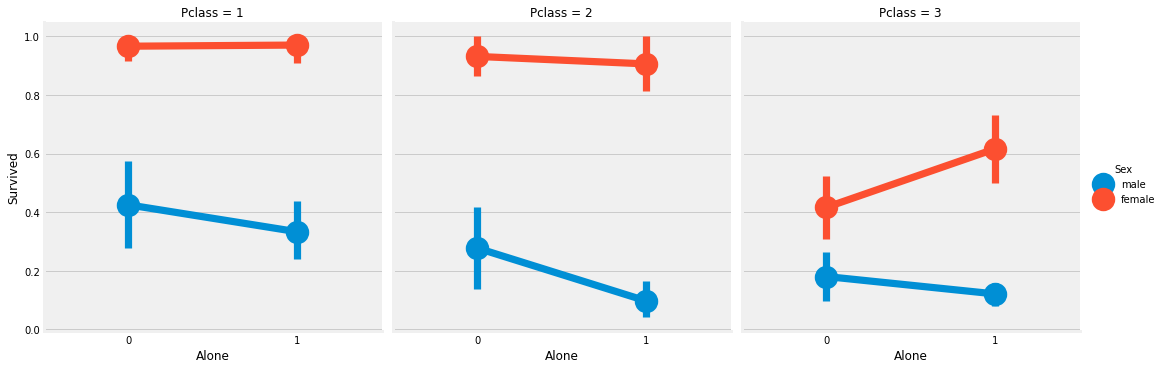

In [46]:
sns.factorplot('Alone','Survived',data=data,hue='Sex',col='Pclass')
plt.show()

여성이 혼자 있는 확률이 가족이 있는 경우보다 높은 pclass3을 제외하면 성별이나 pclass에 상관없이 혼자있는 것이 위험하다는 것을 알 수 있다.

### Fare_Range
Fare 또한 연속형 변수이기 때문에 순서형 변수로 변환할 필요가 있다. 이를 위해 pandas.qcut을 사용한다.

In [47]:
data['Fare_Range'] = pd.qcut(data['Fare'], 4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


위에서 본 것과 같이 요금이 증가할 수록 생존율이 증가한다.
위 Fare_Range 값을 그대로 사용할 수는 없고 Age_Band와 같이 단일 값으로 변환해야 한다.

In [48]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

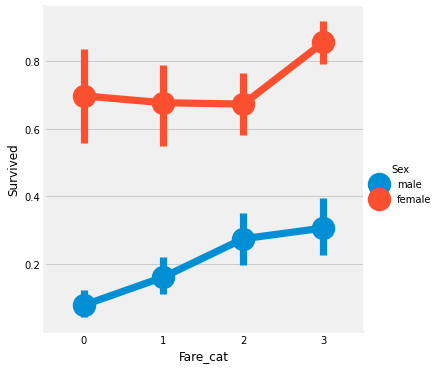

In [49]:
sns.factorplot('Fare_cat','Survived',data=data,hue='Sex')
plt.show()

분명히 Fare_cat이 증가함에 따라 생존율이 증가한다. 이 피쳐는 Sex와 함께 모델링 할때 중요한 피쳐가 될 수 있다.

### Converting String Values into Numeric

머신러닝 모델에 문자열을 전달할 수 없기 때문에 Sex, Embarked 등의 피쳐들을 숫자형으로 바꿔야 한다.

In [50]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

**Dropping UnNeeded Features**


*   Name: 범주형 값으로 변환할 수 없기 때문에 필요 없다.
*   Age: Age_band 피쳐가 있으니 이 피쳐는 더이상 필요 없다.
*   Ticket: 분류할 수 없는 임의의 문자열이다.
*   Fare: Fare_cat 피쳐가 있으니 이제 불필요하다.
*   cabin: NaN값이 많고, 승객들도 여러 객실을 가지고 있다. 이것은 쓸모없는 피쳐이다.
*   Fare_Range: fare_cat피쳐가 있으므로 필요 없다.
*   Passengerld: 분류할 수 없다.









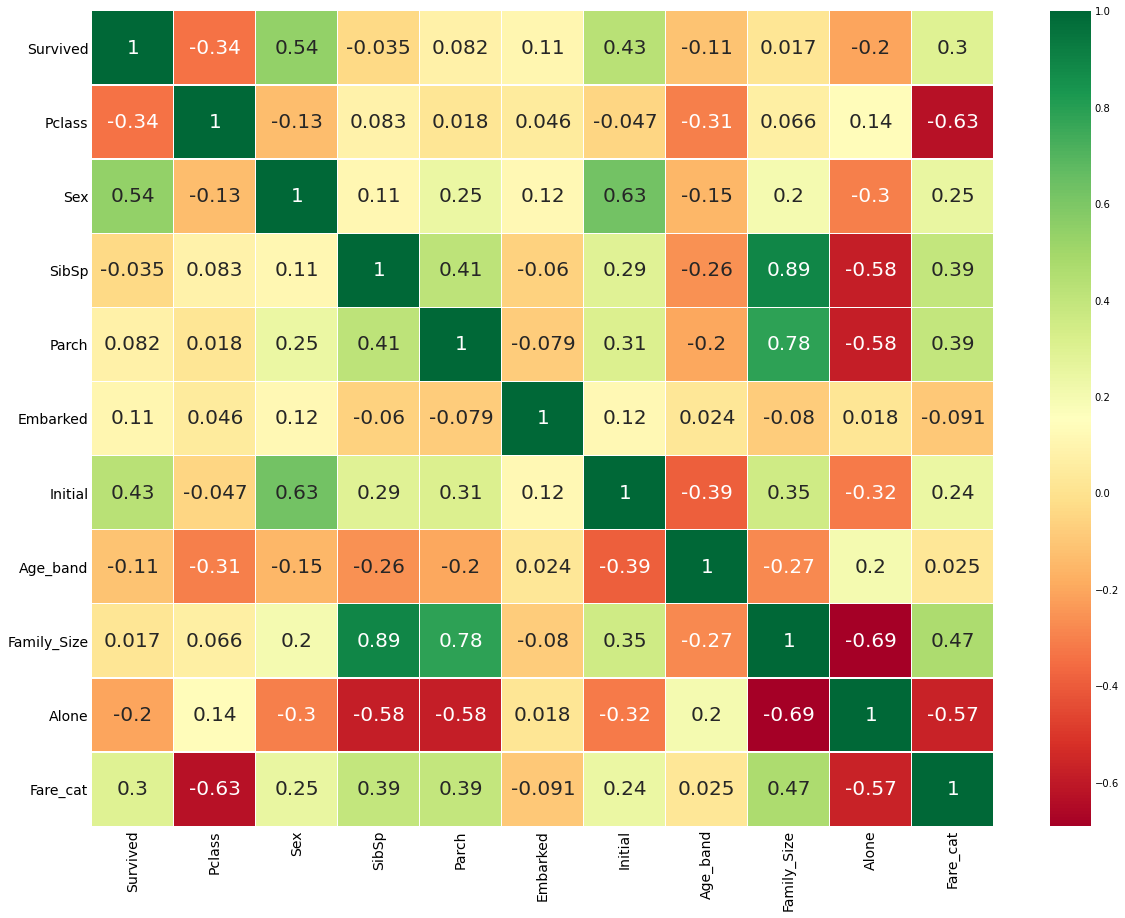

In [51]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Part3: Predictive Modeling

EDA를 통해 몇 가지 인사이트를 얻었다. 그러나 이것만으로는 승객이 생존할 것인지 사망할 것인지 정확하게 예측할 수 없다. 이제 우리는 몇 가지 훌륭한 분류 알고리즘을 사용해서 생존 여부를 예측해볼 것이다.

1) Logistic Regression

2) Support Vector Machines(Linear and radial)

3) Random Forest

4) K-Nearest Neighbours

5) Naive Bayes

6) Decision Tree

7) Logistic Regression



In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [53]:
train, test = train_test_split(data, test_size=0.3, random_state=0, stratify=data['Survived'])
train_X = train[train.columns[1:]]
train_Y = train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

**Radial Support Vector Machines(rbf-SVM)**

In [54]:
model = svm.SVC(kernel='rbf', C=1, gamma=0.1)
model.fit(train_X, train_Y)
prediction1 = model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.835820895522388


**Linear Support Vector Machine(linear-SVM)**

In [55]:
model = svm.SVC(kernel='linear', C=0.1, gamma=0.1)
model.fit(train_X, train_Y)
prediction2 = model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.8171641791044776


**Logistic Regression**

In [56]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.8134328358208955


**Decision Tree**

In [57]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.8134328358208955


**K-Nearest Neighbours(KNN)**

In [58]:
model=KNeighborsClassifier() 
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.832089552238806


KNN에서 n값을 변화시켜보자.

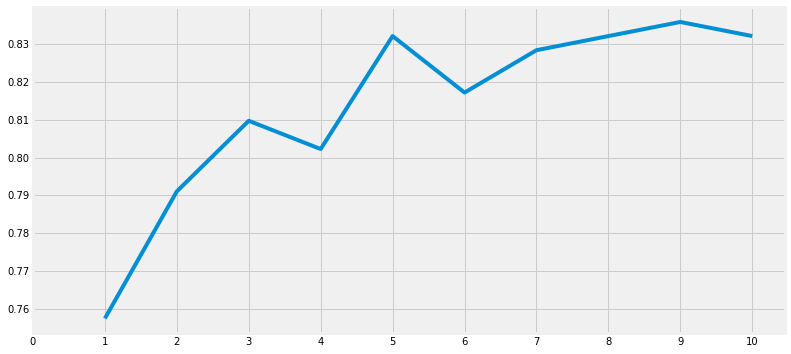

Accuracies for different values of n are: [0.75746269 0.79104478 0.80970149 0.80223881 0.83208955 0.81716418
 0.82835821 0.83208955 0.8358209  0.83208955] with the max value as  0.835820895522388


In [59]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

**Gaussian Naive Bayes**

In [60]:
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


**Random Foreset**

In [61]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.8134328358208955


모델의 정확도만이 분류기의 견고성을 결정하는 요인은 아니다. 분류기가 훈련 데이터에 대해 훈련되고 테스트 데이터에 대해 테스트되었으며 정확도가 90%라고 가정해보자.

이것은 분류기 치고는 매우 좋은 정확도로 보이지만, 새로 도입되는 모든 테스트 세트에 대해 90%가 될 것이라고 확신할 수 있을까? 정답은 "아니오"이다. 훈련 및 테스트 데이터가 바뀜에 따라 정확도도 바뀐다. 증가하거나 감소할 수 있다. 이를 모델의 분산이라고 한다.

이를 극복하고 일반화된 모델을 얻기 위해서 우리는 교차 검증을 사용한다.

### Cross Validation

데이터가 불균형한 경우가 많다. 즉 클래스 1의 인스턴스의 수는 많지만 다른 클래스의 인스턴스 수는 적을 수 있다. 따라서 데이터 세트의 각 인스턴스와 모든 인스턴스에서 알고리즘을 학습시키고 테스트해야한다. 그런 다음 데이터 집합에 대해 모든 정확도를 기록하고 평균으로 계산할 수 있다.

알고리즘은 일부 학습 데이터의 데이터 집합에 대해 과소적합될 수 있으며 다른 학습 세트의 데이터에도 과대적합될 수 있다. 따라서 교차 검증을 통해 일반화된 모델을 달성할 수 있다.

In [62]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [63]:
kfold = KFold(n_splits=10, random_state=22)
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.793471,0.047797
Radial Svm,0.828290,0.034427
Logistic Regression,0.805843,0.024061
KNN,0.813783,0.041210
Decision Tree,0.811473,0.031921
Naive Bayes,0.801386,0.028999
Random Forest,0.812597,0.036090


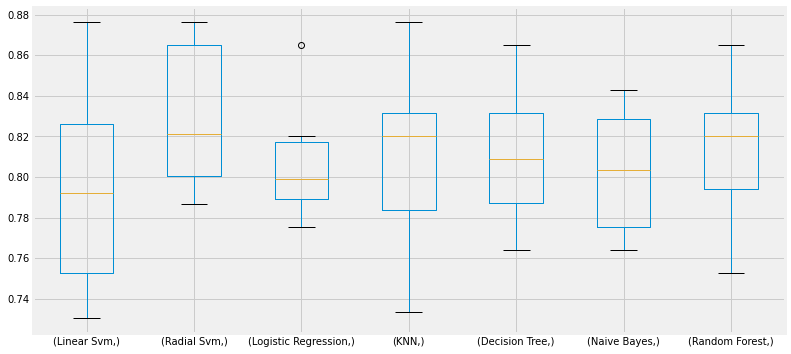

In [64]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

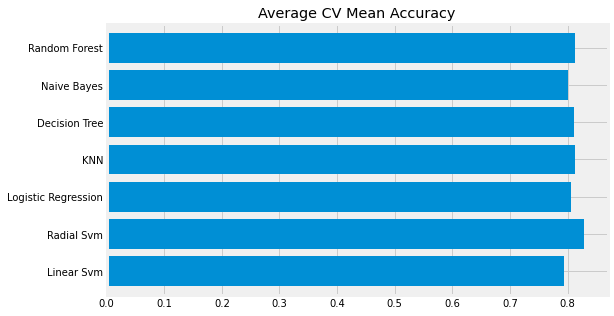

In [65]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

때로는 자료의 불균형으로 인해 분류 정확도가 잘못될 수도 있다. 우리는 혼동행렬로 요약된 결과를 얻을 수 있는데 이것은 모델이 어디에서 잘못되었는지 또는 모델이 어떤 클래스를 잘못 예측했는지 보여준다.

### Confusion Matrix

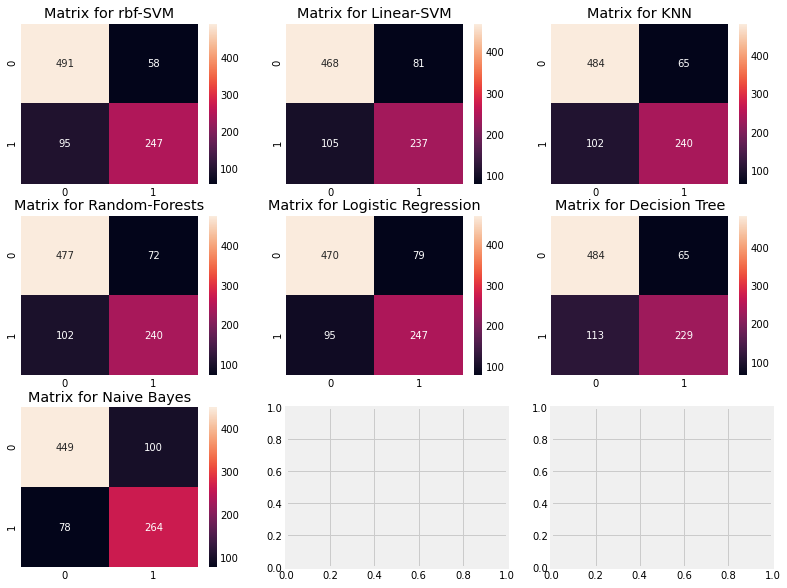

In [66]:
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

모든 행렬을 보면 rbf-SVM이 사망 승객을 정확하게 예측할 가능성이 더 높지만, NaiveBayes는 생존 승객을 더 정확하게 예측할 수 있는 가능성이 더 높다고 말할 수 있다.

### Hyper-Parameters Tuning

**SVM**

In [67]:
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8282593685267716
SVC(C=0.4, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.3, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   23.0s finished


**Random Forests**

In [68]:
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   40.1s finished


0.819327098110602
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


rbf-SVM의 최고 점수는 C=0.05, gamma=0.1 일때 82.82%이다. randomforest는 n_estimators=900일때 약 81.8%이다.

### Ensembling

앙상블링은 모델의 정확도나 성능을 높이는 좋은 방법이다. 간단히 말해 하나의 강력한 모델을 만들기 위해 다양한 간단한 모델을 조합하는 것이다.

1) Voting Classifier

2) Bagging

3) Boosting.

**Voting Classifier**

In [69]:
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(train_X,train_Y)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(test_X,test_Y))
cross=cross_val_score(ensemble_lin_rbf,X,Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.8208955223880597
The cross validated score is 0.8249188514357053


**Bagging**



*   Bagged KNN



In [70]:
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.835820895522388
The cross validated score for bagged KNN is: 0.8160424469413232




*   Bagged DecisionTree



In [71]:
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.8246268656716418
The cross validated score for bagged Decision Tree is: 0.8227590511860174


**Boosting**



*   AdaBoost(Adaptive Boosting)



In [72]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.8249188514357055




*   Stochastic Gradient Boosting



In [73]:
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.8115230961298376




*   XGBoost



In [74]:
import xgboost as xg
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The cross validated score for XGBoost is: 0.8115480649188515




*   Hyper-Parameter Tuning for AdaBoost



In [75]:
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8293892411022534
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=None)


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 10.0min finished


AdaBoost로 얻을 수 있는 최대 정확도는 n_contactator=200, learning_rate=0.05 일 때 83.16%이다.

**Confusion Matrix for the Best Model**

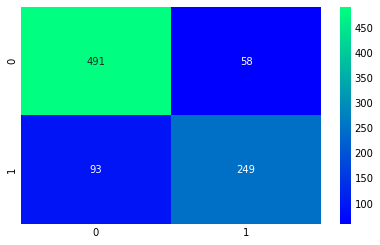

In [76]:
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result=cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

### Feature Importance

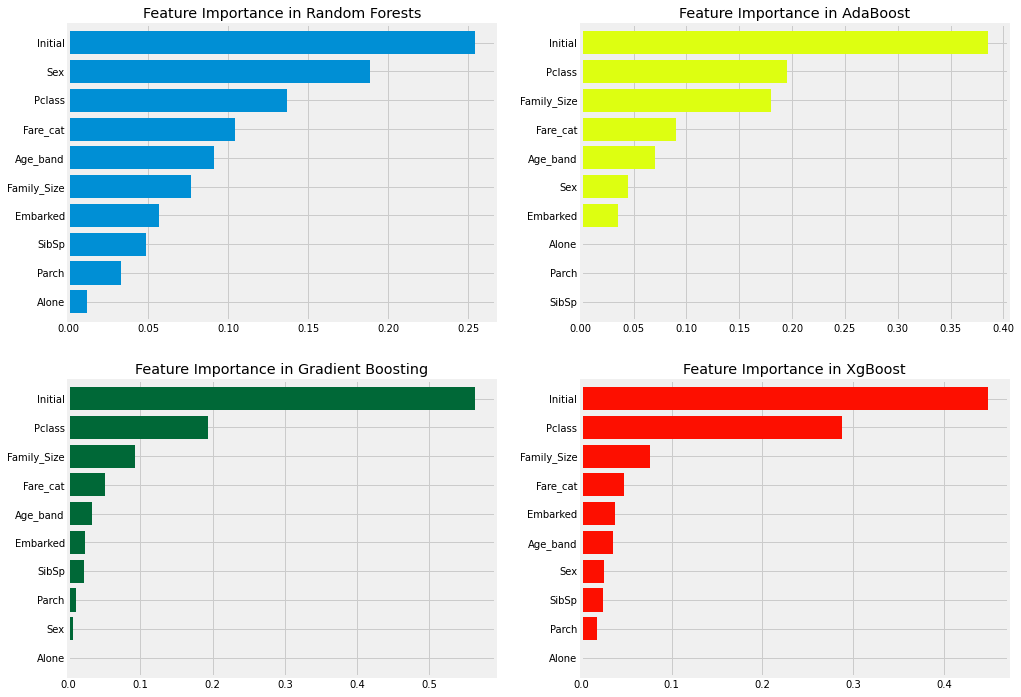

In [77]:
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

랜덤 포레스트, AdaBoost 등과 같은 다양한 분류기의 중요한 피쳐들을 볼 수 있다.

**Observations:**


1.   공통적으로 중요한 피쳐로는 Initial, Fare_cat, Pclass, Family_Size가 있다.
2.   앞에서 봤을 때는 Sex와 Pclass를 결합했는 때 매우 중요한 영향을 미칠 것으로 예상되었지만 Sex의 특징은 별로 중요해보이지 않는다. Sex는 랜덤 포레스트에서만 중요해보인다.

그러나 많은 분류기에서 Initial이 중요한 역할을 했는데, Sex와 Initial은 양의 상관관계를 보였고, Initial 또한 성별의 정보를 가지고 있다.


